- Notes
    - **transaction status**
        - Returned: price is zero, quantity is negative, invoice number doesn't have leading C, description may tell the cause
        - Cancelled: invoice has leading C, quantity is negative, price is positive, and NOT single items are cancelled (only whole purchase is cancelled)
        - Other: they may be anomalies 
        - Delivered:
    
    

In [63]:
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import warnings
warnings.filterwarnings("ignore")



In [2]:
def apply_regex_matching(object_pattern, phrase):
    # Use re.findall to find and capture the pattern in the input phrase
    phrase = phrase.replace('NECKL','NECKLace')
    phrase = re.sub(r'^ASS', 'ASSORTED', phrase)
    phrase = phrase.strip()
    matches = re.findall(object_pattern, phrase, flags=re.IGNORECASE)
    if matches:
        #matches = [match.replace(' ','') for match in matches]
        return matches
    else:
        return phrase

def refine_category(text):
    # Initialize spell checker and lemmatizer
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    # Text with potential spelling errors
    # Split the text into words and correct spelling errors
    words = text.split()
    corrected_words = [spell.correction(word) for word in words]   
    # Lemmatize the corrected words to singular form
    lemmatized_words = [lemmatizer.lemmatize(word) for word in corrected_words]   
    # Join the lemmatized words into a sentence
    corrected_text = " ".join(lemmatized_words)
    return corrected_text

def get_category_mapping():
    # Define a regular expression pattern to capture 'door mat' and return 'doormat'
    first_pattern = r"door\s?mat|candle|light|canvas|mirror|book|earrings|bracelet|backpack|sticker|pencil|"\
                     "drawer|table|chair|case|cutter|lamp|ballo+n|photo|decoration|mug|towel|\sbox\s|"\
                     "purse|cushion\s?cover|charger|necklace|jewel+ery|cutlery|bowl|basket|comb|fragance|key\s?ring|\spen|scale|boxes|"\
                     "tea\s?set|placemat|apron|tags|coat\s?rack|plate|toy|suction\scup|mould|straws|playing\s?cards|letters|ribbon|"\
                     "\scard\s|flask|blackboard|wall\sart|lantern|balls|cushion|umbrella|frame|wrap|coaster|clock|marbles|stones|sign|"\
                     "cabinet|\sstool|charm|stand|doilies|hanger|chain|tea\sglass|magnets|shelf|jewel|fragrance|tea\s?spoon|"\
                     "perfume|card\s?holder|gems|hair|beaded\scrystal|biscuit\stin|spoon|harmonica|cover|^card|bird\s?house|"\
                     "bottle|fork|tray|shoes|tissue|envelope|chalice|holder|matches|hook|wicker|pot|dresser|doorstop|\sjar|calculator|"\
                     "cake\stin|sock|\sglove|card|cards|\sbin\s|headphones|collar|parasol|\sbin|beaker|\scard,|bank|spade|dish|planter|"\
                     "baby\s+gift|bicycle|dispenser|artificial\sflower|container|journal|wooden|doorknob|\span\s|organiser|chalkboard|mobile|"\
                     "calendar|jingle\sbell|doll|balloon|scissor|christmas\stree|scarf|\sbin\,|sponge|peg|vase|decorative|key\sfob|"\
                     "thermometer|jigsaw|tag$|\smat\s|\stins\s|\scan\s|\stins$|hanging|assorted"
    
    second_pattern = r"\sring|card|\sbox$|glass$|jug|wood\s|magnet|tape|\s?bag\s|\sdoll\s|bag$|^bag\s|bags$|\stin\s|tin$|brush|cup|cream$|game|"\
                     "bathroom|curtain|croche|ladder|incense|brooch|bell|tile|board|teddy\sbear|easter|christmas|child|craft|hand\sopen|drawing|"\
                     "\sslate|^paper|invites|antique|vintage"
    
    holiday = r'christmas|eastern|birthday'

    df = pd.read_csv("description.csv")
    df = pd.DataFrame(df, columns=['description', 'category'])
    
    df['category'] = df['description'].apply(lambda x: apply_regex_matching(first_pattern, x))
    df['category'] = df['category'].apply(lambda x: apply_regex_matching(second_pattern, x) if isinstance(x, str) else x)
    df['category'] = df['category'].apply(lambda x: x[0] if isinstance(x,list) else 'miscelleneous')
    
    df['holiday'] = df['description'].apply(lambda x: apply_regex_matching(holiday, x))
    df['holiday'] = df['holiday'].apply(lambda x: x[0] if isinstance(x,list) else np.nan)
    df['category'] = df['category'].apply(lambda x: refine_category(x.lower()))

    return df

In [3]:
def read_input_file(sheet_name):
    dtypes = {'Invoice': str, 'StockCode': str, 'Description':str, 'Quantity': int, 
              'Price':float, 'Customer ID': str, 'Country':str}
    df = pd.read_excel("online_retail_II.xlsx", sheet_name=sheet_name, 
                       dtype=dtypes, parse_dates=['InvoiceDate'])
    df.columns = df.columns.str.lower()
    return df

def tranx_status(x):
    description = x['description']
    invoice = x['invoice']
    quantity = x['quantity']
    price = x['price']

    if isinstance(description, str) and ('fees' in description.lower() or 'charges' in description.lower()):
        return 'Fees'
    elif isinstance(invoice, str) and invoice[0] == 'C':
        return 'Cancelled'
    elif isinstance(invoice, str) and invoice[0] == 'A':
        return 'Unknown'
    elif quantity < 0 and price == 0:
        return 'Returned'
    elif pd.isna(quantity) or (quantity >= 0 and price == 0):
        return 'Unknown'
    else:
        return 'Delivered'

In [24]:
data2009 = read_input_file("Year 2009-2010")
data2010 = read_input_file("Year 2010-2011")
category = get_category_mapping()

df = pd.concat([data2009, data2010]).reset_index(drop=1)
df['tranx_status'] = df.apply(tranx_status, axis=1)
df = df.merge(category, on=['description'], how='left')
df['total_price'] = df['price'] * df['quantity']
df['day'] = df['invoicedate'].dt.day_name()
df['date'] = df['invoicedate'].dt.date
df['temp_invoice'] = df['invoice'].apply(lambda x: re.sub(r'[^0-9]', '', x))
df['month'] = df['date'].apply(lambda date: date + pd.offsets.MonthEnd(0))

In [37]:
print('df shape', df.shape)

print("\nCount of count, unique, missing values")
for column in df.columns:
    unique_count = df[column].nunique()
    count = df[column].count()
    missing = df[column].isna().sum()
    print(f"{column}: {count}, {unique_count}, {missing}")
    
display(df.describe())

df shape (1067371, 16)

Count of count, unique, missing values
invoice: 1067371, 53628, 0
stockcode: 1067371, 5305, 0
description: 1062989, 5698, 4382
quantity: 1067371, 1057, 0
invoicedate: 1067371, 47635, 0
price: 1067371, 2807, 0
customer id: 824364, 5942, 243007
country: 1067371, 43, 0
tranx_status: 1067371, 5, 0
category: 1056387, 181, 10984
holiday: 57188, 2, 1010183
total_price: 1067371, 9113, 0
day: 1067371, 7, 0
date: 1067371, 604, 0
temp_invoice: 1067371, 53628, 0
month: 1067371, 25, 0


,quantity,price,total_price
count,1.067371e+06,1.067371e+06,1.067371e+06
mean,9.938898e+00,4.649388e+00,1.806987e+01
std,1.727058e+02,1.235531e+02,2.924202e+02
min,-8.099500e+04,-5.359436e+04,-1.684696e+05
25%,1.000000e+00,1.250000e+00,3.750000e+00
50%,3.000000e+00,2.100000e+00,9.900000e+00
75%,1.000000e+01,4.150000e+00,1.770000e+01
max,8.099500e+04,3.897000e+04,1.684696e+05


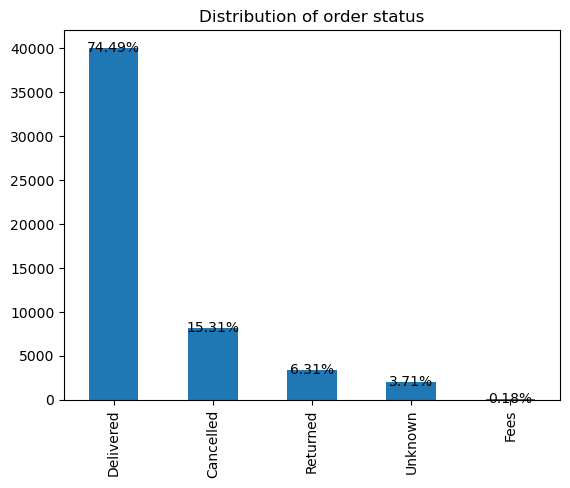

In [19]:
data = df[['invoice', 'tranx_status']].drop_duplicates()
value_counts = data['tranx_status'].value_counts()

# Create the bar plot
ax = value_counts.plot(kind='bar', title='Distribution of order status')

# Add percentages to the bars
total = value_counts.sum()
for i in ax.patches:
    ax.annotate(f'{i.get_height()/total*100:.2f}%', (i.get_x() + i.get_width() / 2., i.get_height()), ha='center', va='center')

plt.show()

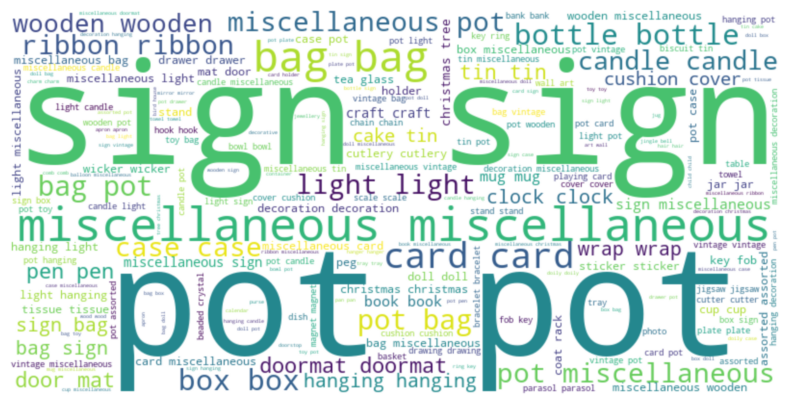

In [36]:
# Replace the text variable with your own text data
text = " ".join(df[['category']].dropna()['category'].values)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bicubic')
plt.axis('off')  # Remove axis
plt.show()


### Cancelled Orders

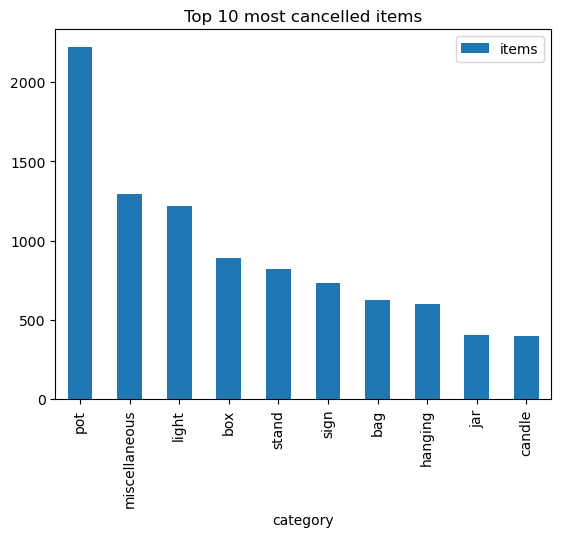

In [20]:
cancelled_items = df[df['tranx_status']=='Cancelled'].groupby(['category']).size().sort_values(ascending=False).reset_index(name='items')
cancelled_items.iloc[:10,:].plot(kind='bar', x='category', y='items', title='Top 10 most cancelled items')
plt.show()

<Axes: title={'center': 'Total Invoiced Cancelled'}, xlabel='month'>

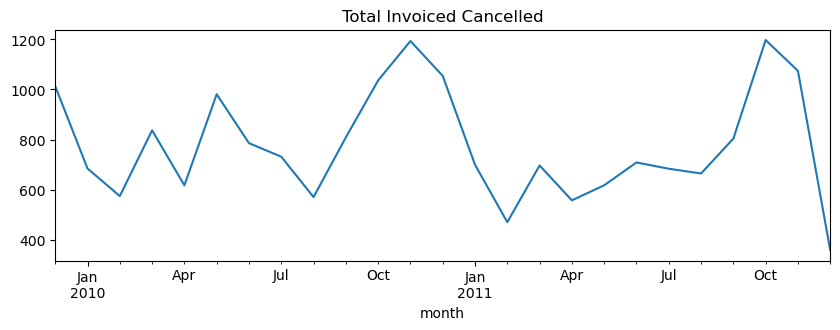

In [29]:
df[df['tranx_status']=='Cancelled'].groupby(['month']).size().plot(figsize=(10,3), title='Total Invoiced Cancelled')

### Delivered Orders

In [41]:
delivered = df[df['tranx_status']=='Delivered'].copy()
delivered = delivered.dropna(subset='description')
delivered['price_per_item'] = delivered['price']/delivered['quantity']

x = delivered.shape[0]
y = delivered[delivered['quantity']>50].shape[0]
print(f"total count: {x}, counts above quantity 50: {y}, percentage: {(y/x)*100}")

delivered = delivered[delivered['quantity']<50].reset_index(drop=1)

total count: 1041634, counts above quantity 50: 24316, percentage: 2.3344092070727336


/var/folders/f3/ttk43vxd4bx5mqc_1z0fpfnr0000gn/T/ipykernel_59860/875249946.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(data['category'], rotation=45, ha='right')


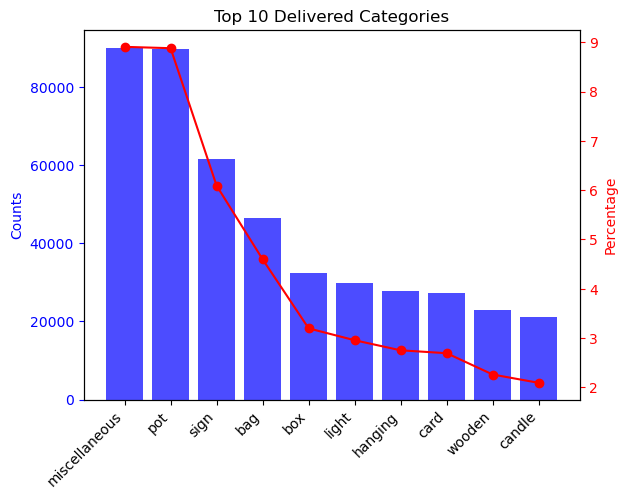

In [56]:
agg_items = delivered.groupby(['category']).size().sort_values(ascending=False).reset_index(name='counts')
agg_items['pct'] = agg_items['counts']/agg_items['counts'].sum() * 100
agg_items = agg_items.sort_values('pct', ascending=False).reset_index(drop=1).iloc[:10]
data = agg_items.copy()

# Create a figure and axis
fig, ax1 = plt.subplots()

# Bar chart for 'counts' on the left y-axis
ax1.bar(data['category'], data['counts'], color='b', alpha=0.7)
ax1.set_ylabel('Counts', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticklabels(data['category'], rotation=45, ha='right')

# Create a second y-axis
ax2 = ax1.twinx()

# Line plot for 'pct' on the right y-axis
ax2.plot(data['category'], data['pct'], marker='o', color='r', linestyle='-')
ax2.set_ylabel('Percentage', color='r')
ax2.tick_params('y', colors='r')

# Set the title and labels
plt.title('Top 10 Delivered Categories')
plt.xlabel('Category')
plt.show()

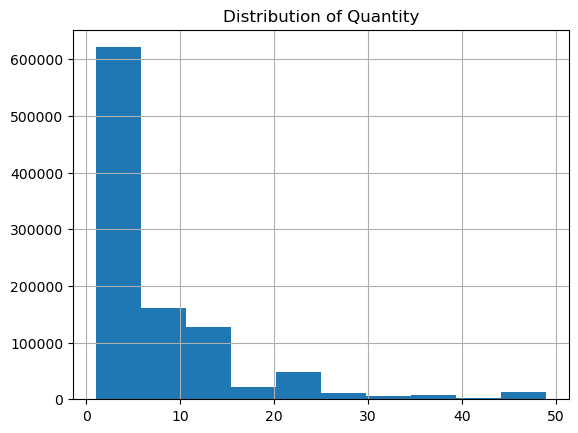

In [47]:
delivered[delivered['quantity']<50][['quantity']].hist()
plt.title("Distribution of Quantity")
plt.show()

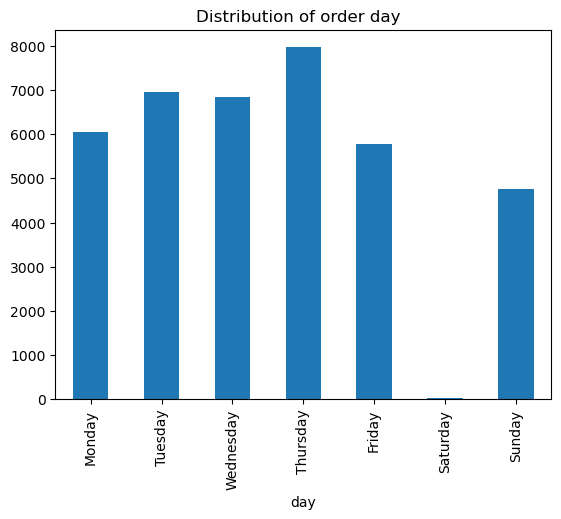

In [48]:
day_invoice = delivered.groupby(['day'])['invoice'].nunique()

week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_invoice = day_invoice.reindex(week_order, fill_value=0)
day_invoice.plot(kind='bar', title='Distribution of order day  ')
plt.show()

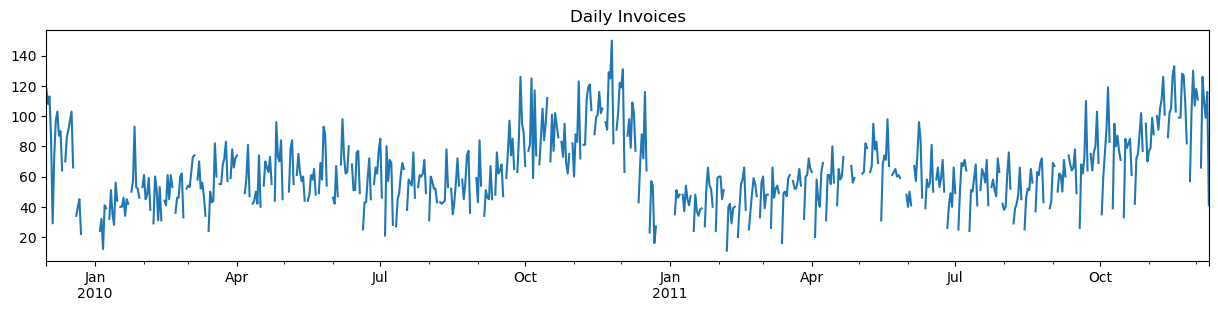

In [49]:
daily_invoice = delivered.groupby(['date'])['invoice'].nunique()

full_date_range = pd.date_range(start=daily_invoice.index.min(), end=daily_invoice.index.max())
daily_invoice = daily_invoice.reindex(full_date_range)
daily_invoice.plot(figsize=(15,3), title='Daily Invoices')
plt.show()

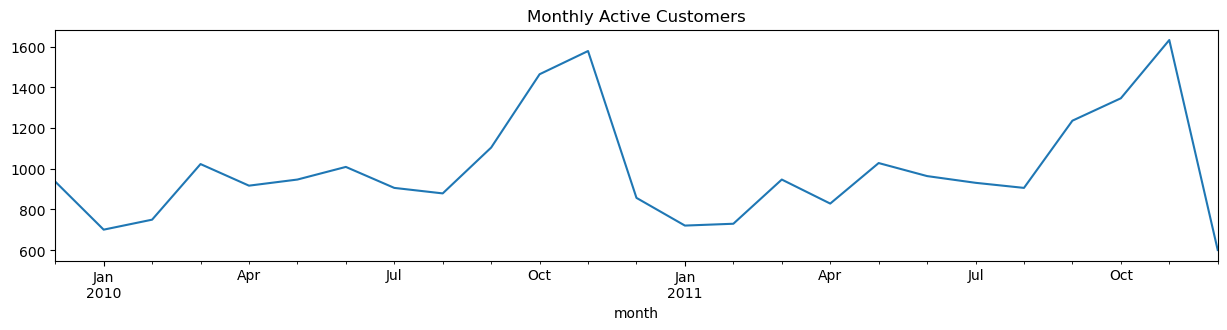

In [50]:
monthly_customers = delivered.groupby(['month'])['customer id'].nunique()
monthly_customers.plot(figsize=(15,3), title='Monthly Active Customers')
plt.show()

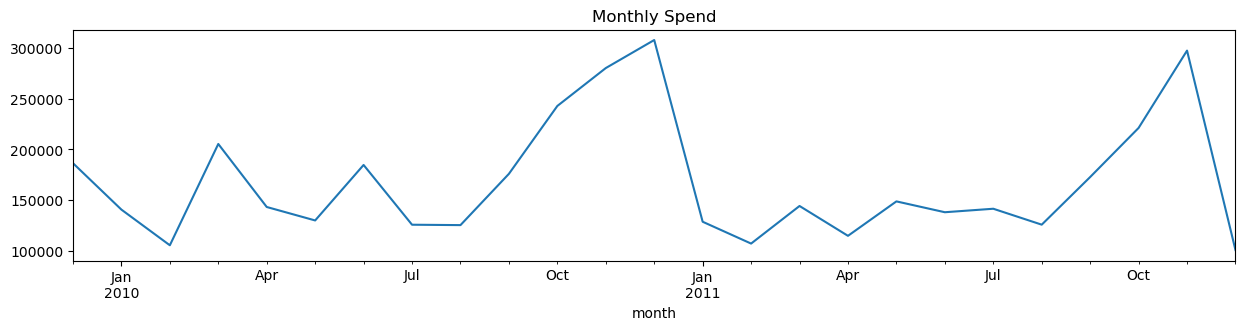

In [51]:
monthly_spend = delivered.groupby(['month'])['price'].sum()
monthly_spend.plot(figsize=(15,3), title='Monthly Spend')
plt.show()

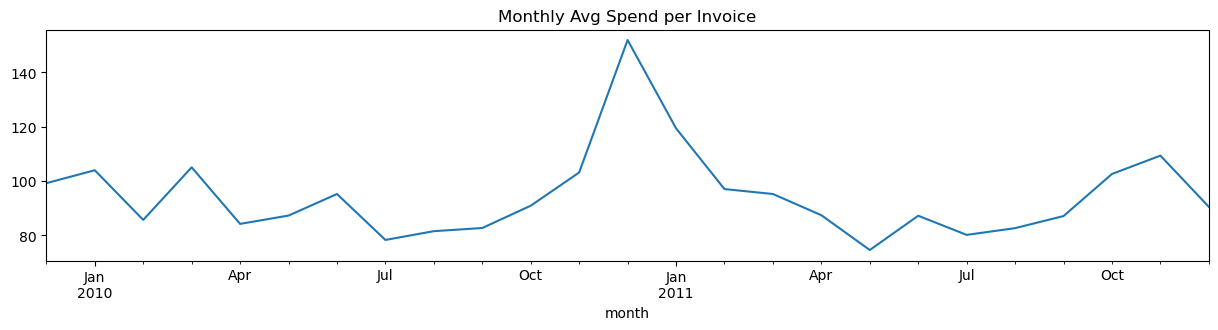

In [52]:
daily_agg = delivered.groupby(['date']).agg({'price':'sum', 'invoice':'nunique'}).reset_index()
daily_agg['avg_per_invoice'] = daily_agg['price']/daily_agg['invoice']
daily_agg['month'] = daily_agg['date'].apply(lambda date: date + pd.offsets.MonthEnd(0))
daily_agg.groupby(['month'])['avg_per_invoice'].median().plot(title='Monthly Avg Spend per Invoice', figsize=(15,3))
plt.show()

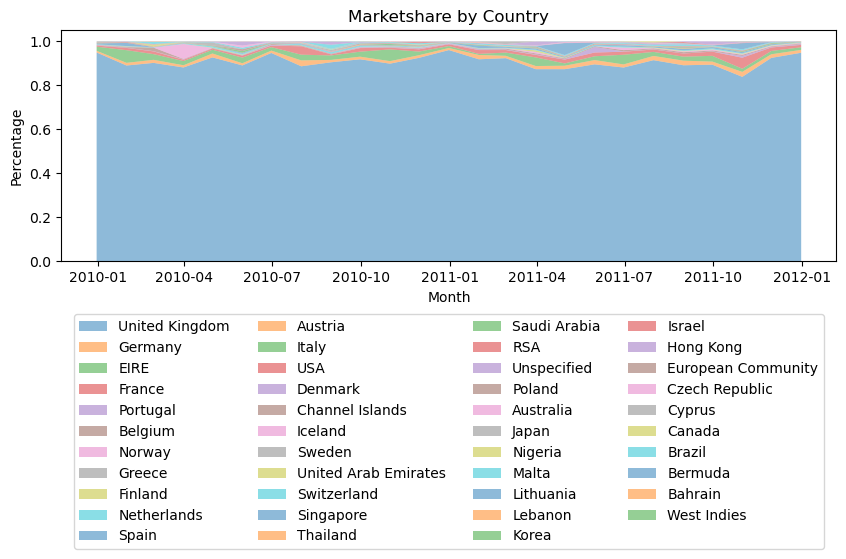

In [54]:
fig, ax = plt.subplots(figsize=(10, 3))
agg_country = delivered.groupby(['month','country'])['price'].sum().reset_index()
pivot_df = agg_country.pivot(index='month', columns='country', values='price').fillna(0)
# Normalize the data for 100% stacked area chart
pivot_df_norm = pivot_df.divide(pivot_df.sum(axis=1), axis=0)
# Sort the DataFrame by the values in the row '2010-04' in descending order
pivot_df_norm = pivot_df_norm.sort_values(by=pivot_df_norm.index.max(), axis=1, ascending=False)

# Create the 100% stacked area chart
plt.stackplot(pivot_df_norm.index, pivot_df_norm.values.T, labels=pivot_df_norm.columns, alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
# Customize the plot
plt.xlabel("Month")
plt.ylabel("Percentage")
plt.title("Marketshare by Country")
# Show the chart
plt.show()


### Customer Segmentation

/Users/lilianacruzlopez/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/f3/ttk43vxd4bx5mqc_1z0fpfnr0000gn/T/ipykernel_59860/807885470.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = delivered_encoded.groupby('cluster').mean()


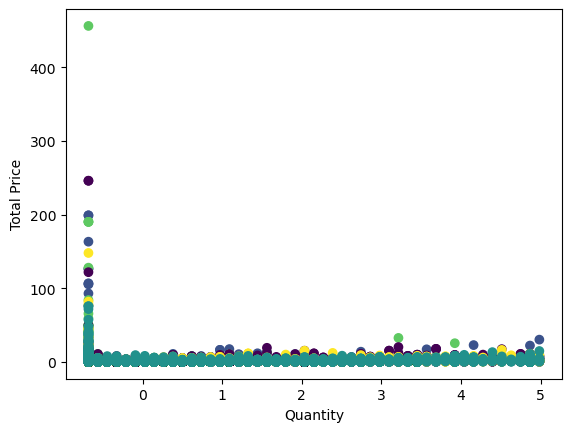

In [57]:
# One-hot encode the 'category' column
delivered_encoded = delivered.drop(columns=['invoice', 'date', 'day', 'month', 'stockcode', 'description', 'invoicedate', 
                                                    'price', 'customer id', 'country', 'tranx_status', 'holiday', 'stockcode'], axis=1)
delivered_encoded = pd.get_dummies(delivered_encoded, columns=['category'], prefix=['category'])
scaler = StandardScaler()

delivered_encoded[['total_price', 'quantity']] = scaler.fit_transform(delivered_encoded[['total_price', 'quantity']])

X = delivered_encoded.copy()

from sklearn.cluster import KMeans

# Initialize the KMeans model with the desired number of clusters (e.g., 5)
kmeans = KMeans(n_clusters=5, random_state=0)

# Fit the model to your data
kmeans.fit(X)

# Add the cluster labels to your DataFrame
delivered_encoded['cluster'] = kmeans.labels_

# Now, `df` contains a new column 'cluster' indicating the cluster assignment for each row

# You can analyze the clusters by, for example, calculating cluster means:
cluster_means = delivered_encoded.groupby('cluster').mean()

# Or you can visualize the clusters
plt.scatter(delivered_encoded['quantity'], delivered_encoded['total_price'], c=delivered_encoded['cluster'])
plt.xlabel('Quantity')
plt.ylabel('Total Price')
plt.show()


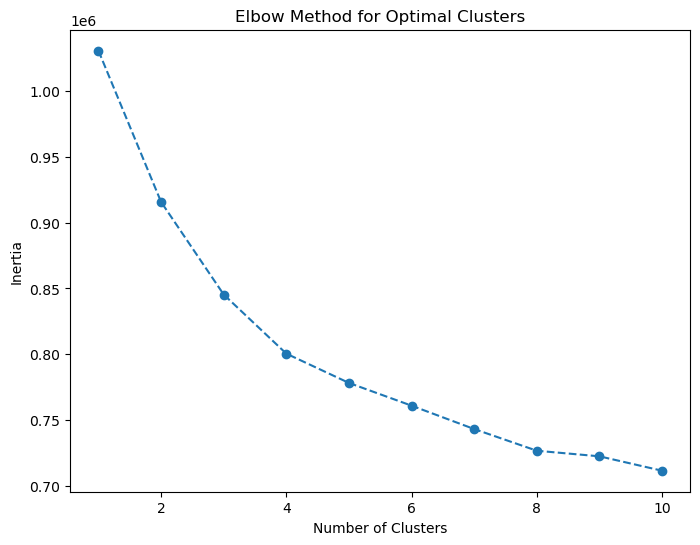

In [64]:
df_agg = delivered.groupby(['customer id', 'category'])['quantity'].sum().reset_index()
pivot_table = df_agg.pivot(index='customer id', columns='category', values='quantity').fillna(0)

# Assuming you have your data in 'pivot_table'
# Select relevant columns for clustering
X = pivot_table.values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the number of clusters using the Elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# From the Elbow curve, select the optimal number of clusters (e.g., 3)
optimal_clusters = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original data
pivot_table['Cluster'] = cluster_labels

In [87]:
data = delivered.groupby(['month']).agg({'total_price':'sum'})
display(data.tail())
data = data.iloc[:-1,:]

,total_price
month,
2011-08-31,523043.990
2011-09-30,762496.431
2011-10-31,846210.650
2011-11-30,1128364.230
2011-12-31,353957.990


In [89]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data['total_price'])


Results of Dickey-Fuller Test:
Test Statistic                 -5.121586
p-value                         0.000013
#Lags Used                      9.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


In [88]:
# Fit an ARIMA model
model = ARIMA(data['total_price'], order=(1, 1, 1))  # You may need to adjust the order parameters
results = model.fit()

forecast_steps = 1
forecast_results = results.get_forecast(steps=forecast_steps, alpha=0.05)  # Specify the confidence level (e.g., alpha=0.05)

# Extract the forecasted values and the associated confidence intervals
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Print the forecasted value and confidence interval
next_month = data.index[-1] + pd.DateOffset(months=1)
print(f'Forecast for {next_month}: {forecast[0]}')
print(f'95% Confidence Interval: ({conf_int.iloc[0, 0]}, {conf_int.iloc[0, 1]})')


Forecast for 2011-12-30 00:00:00: 1071641.0300830489
95% Confidence Interval: (727407.1526890335, 1415874.907477064)


/Users/lilianacruzlopez/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/lilianacruzlopez/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/lilianacruzlopez/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
